In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy


# Mackey Glass Dataset

In [3]:
import sys
sys.path.append('..')

from Datasets.MackeyGlassDataset import MackeyGlassDataset

In [4]:
Mglass = MackeyGlassDataset(20, 100)

In [5]:
import torch
from torch.utils.data import DataLoader

train_loader = DataLoader(Mglass, batch_size=1, shuffle=True)

In [6]:
# Parameters
beta = 0.2
gamma = 0.1
n = 10
tau = 17
t_max = 300
dt = 0.1
history = 1.2  # Initial condition for t < 0

In [7]:
def mackey_glass(n, tau, beta, gamma, t_max, dt, history):
    x = np.zeros((n, int(t_max/dt)))
    x[:, 0] = history
    for t in range(1, int(t_max/dt)):
        for i in range(n):
            x[i, t] = x[i, t-1] + dt * (beta * x[i, t-1-tau] / (1 + x[i, t-1-tau]**n) - gamma * x[i, t-1])
    return x

In [8]:
# Time range
time = np.arange(0, t_max, dt)
x = np.zeros(len(time))

# Initial history (for t < 0, assume a constant value)
x[:int(tau / dt)] = history 


In [9]:
# Euler method to integrate the Mackey-Glass equation
for t in range(int(tau/dt), len(time) - 1):
    x_t_tau = x[t - int(tau/dt)]  # Value of x(t - tau)
    x[t + 1] = x[t] + dt * (beta * x_t_tau / (1 + x_t_tau**n) - gamma * x[t])

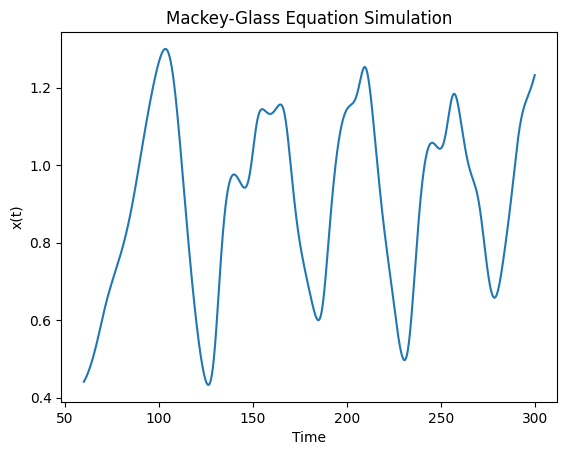

In [10]:
# Plot the generated data
plt.plot(time[600:], x[600:])
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Equation Simulation')
plt.show()

## Mackey_Glass Class

# RESERVOIR

In [11]:
import torch
import torch.nn as nn
import torch.optim

In [12]:
class Reservoir (nn.Module):
    def __init__(self):
        pass

    def forward(self):
        pass

    def initReservoir(self):
        pass

In [13]:
def hump_function(x, b, n, gamma):
    #x_t_tau = x[t - int(tau/dt)]
    return b * x / (1 + x**n) - gamma * x

def plot_hump(x):
    plt.plot(x, h1)
    #plt.plot(x, h2)
    #plt.plot(x, h2)
    plt.plot(x, h4)
    #plt.plot(x, h5)
    #plt.plot(x, h5)
    plt.xlabel('x')
    plt.ylabel('h(x)')
    plt.title('Hump Function')
    plt.legend(['b=0.1, n=1', 'b=0.1, n=2', 'b=0.1, n=3', 'b=0.2, n=1', 'b=0.2, n=2', 'b=0.2, n=3'])
    plt.show()

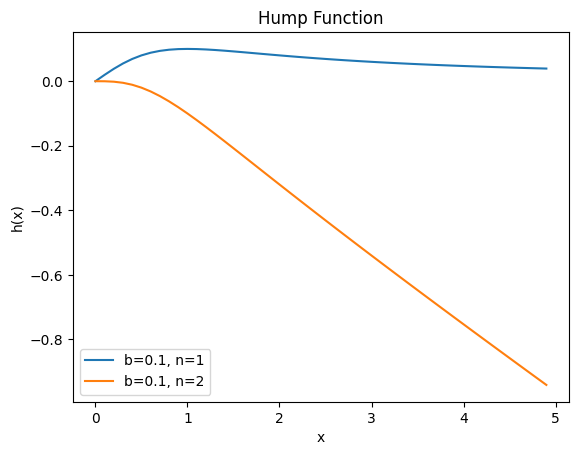

In [14]:
x_axis = np.arange(0, 5, 0.1)
h1 = hump_function(x_axis, 0.2, 2, 0)
#h2 = hump_function(x, 0.1, 3)
#h3 = hump_function(x, 0.1, 5)

h4 = hump_function(x_axis, 0.2, 2, 0.2)
#h5 = hump_function(x, 0.2, 3)
#h6 = hump_function(x, 0.2, 5)

plot_hump(x=x_axis)


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # Import the functional module
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt  # Added import for visualization

class Reservoir(nn.Module):
    def __init__(self, input_size, reservoir_size, output_size):
        super(Reservoir, self).__init__()
        self.reservoir_size = reservoir_size
        self.W_in = nn.Linear(input_size, reservoir_size, bias=False)  # Input weights
        self.W_h = nn.Linear(reservoir_size, reservoir_size, bias=False)  # Recurrent weights
        self.W_out = nn.Linear(reservoir_size, output_size, bias=False)  # Output weights

        # Initialize the recurrent weights randomly (fixed during training)
        nn.init.orthogonal_(self.W_h.weight)  # A common initialization for stability

    def forward(self, x, reservoir_state):
        # Calculate new reservoir state using Wx + W_hh
        reservoir_state = torch.tanh(self.W_in(x) + self.W_h(reservoir_state))
        
        # Output layer
        output = self.W_out(reservoir_state)

        return output, reservoir_state

    def initReservoirState(self):
        # Initialize the reservoir state as zeros
        return torch.zeros(1, self.reservoir_size, dtype=float)

In [16]:
reservoir1 = Reservoir(input_size = 3000, reservoir_size = 1000, output_size = 10)

In [17]:
x = torch.from_numpy(x).type(torch.float32)

In [18]:
reservoir1, x.shape

(Reservoir(
   (W_in): Linear(in_features=3000, out_features=1000, bias=False)
   (W_h): Linear(in_features=1000, out_features=1000, bias=False)
   (W_out): Linear(in_features=1000, out_features=10, bias=False)
 ),
 torch.Size([3000]))